In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
import multivae
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import gc
import os
import tensorflow as tf
import keras
from sklearn.neural_network import MLPClassifier

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-package

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format='retina'

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [7]:
SCRNA_DIR = '../data/scRNA/'
SCATAC_DIR = '../data/scATAC/peaks/'

## scRNA

In [8]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')
scrna = scrna[scrna.obs['condition'] == 'control']
scrna

CPU times: user 484 ms, sys: 136 ms, total: 620 ms
Wall time: 620 ms


View of AnnData object with n_obs × n_vars = 35582 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

## scATAC

In [9]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')
scatac = scatac[scatac.obs['condition'] == 'control']
scatac

CPU times: user 1.34 s, sys: 5.58 s, total: 6.92 s
Wall time: 11.9 s


View of AnnData object with n_obs × n_vars = 35038 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    obsm: 'X_umap'

In [10]:
n_samples = min(scrna.shape[0], scatac.shape[0])
scrna_sample_indices = np.random.choice(scrna.shape[0], size=n_samples, replace=False)
scatac_sample_indices = np.random.choice(scatac.shape[0], size=n_samples, replace=False)
scrna = scrna[scrna_sample_indices]
scatac = scatac[scatac_sample_indices]
print(scrna.shape, scatac.shape)

(35038, 3000) (35038, 20002)


# Train the model

In [11]:
network = multivae.archs.MultiTrVAE([scrna.shape[1], scatac.shape[1]],
                                    n_conditions=2,
                                    z_dimension=20,
                                    architecture=[128, 128, 64, 64, 32, 32],
                                    eta=1,
                                    gamma=1,
                                    alpha=1,
                                    beta=1,
                                    output_activations=['relu', 'sigmoid'],
                                    reconstruction_losses=['mse', 'bce'],
                                    model_path='./models/multitrvae/')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "multi_trvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_0 (InputLayer)             (None, 3000)         0                                            
__________________________________________________________________________________________________
encoder_labels_0 (InputLayer)   (None, 2)            0                                            
__________________________________________________________________________________________________
data_1 (InputLayer)             (None, 20002)        0                                            
__________________________________________________________________________________________________
encoder_labels_1 (InputLayer)   (None, 2)            0                                     

In [ ]:
history = network.train([scrna, scatac], n_epochs=250, batch_size=64, verbose=2, lr_reducer=50, early_stop_limit=70)

Train on 28030 samples, validate on 7008 samples
Epoch 1/250
 - 90s - loss: 18212.5734 - decoder_0_loss: 279.3608 - decoder_1_loss: 8758.2422 - decoder_0_recon_loss: 279.3656 - decoder_0_cycle_loss_1: 282.6694 - decoder_0_kl_loss: 1.0805 - decoder_0_modals_mmd_loss: 0.0289 - decoder_0_conditions_mmd_loss: 0.0000e+00 - decoder_1_recon_loss: 8758.2949 - decoder_1_cycle_loss_0: 8889.6641 - decoder_1_kl_loss: 1.4634 - decoder_1_modals_mmd_loss: 0.0289 - decoder_1_conditions_mmd_loss: 0.0000e+00 - val_loss: 46947.2408 - val_decoder_0_loss: 205.0030 - val_decoder_1_loss: 8356.1426 - val_decoder_0_recon_loss: 205.0380 - val_decoder_0_cycle_loss_1: 314.6220 - val_decoder_0_kl_loss: 2.5336 - val_decoder_0_modals_mmd_loss: 0.0430 - val_decoder_0_conditions_mmd_loss: 0.0000e+00 - val_decoder_1_recon_loss: 8358.2949 - val_decoder_1_cycle_loss_0: 38063.6055 - val_decoder_1_kl_loss: 3.1096 - val_decoder_1_modals_mmd_loss: 0.0430 - val_decoder_1_conditions_mmd_loss: 0.0000e+00
Epoch 2/250
 - 66s - lo

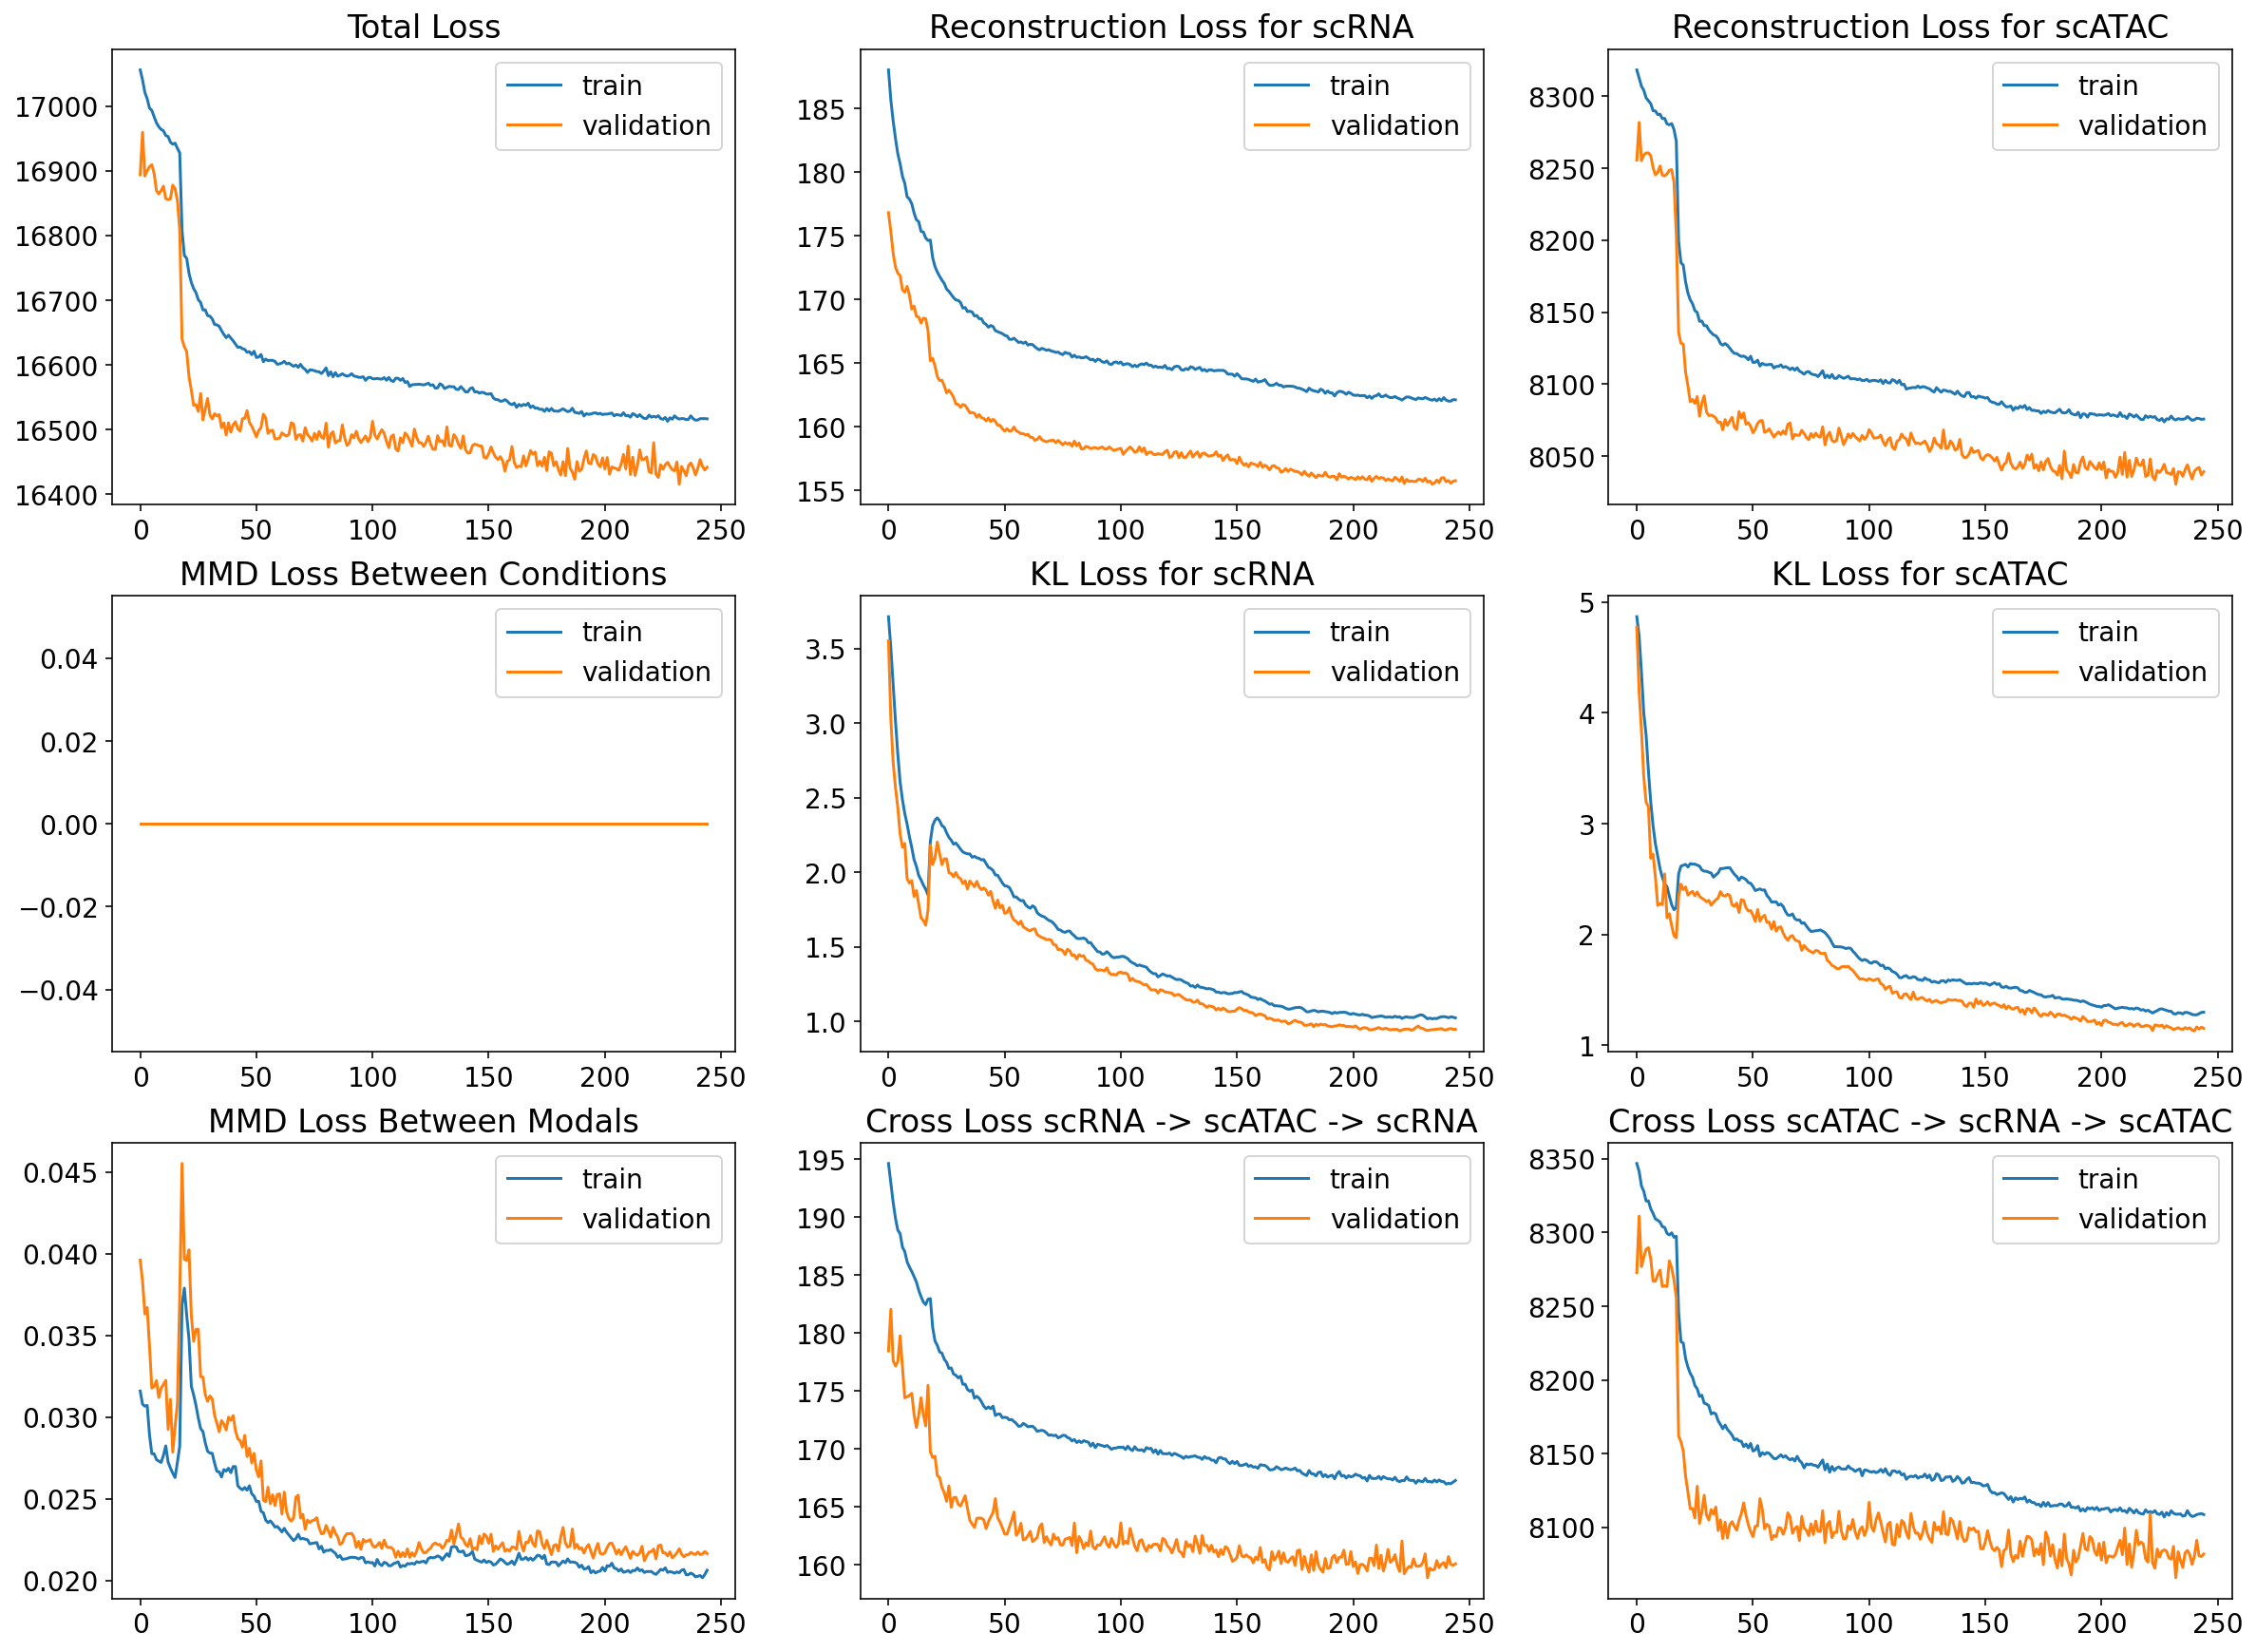

In [16]:
from_epoch = 5

plt.figure(figsize=(20, 15));

plt.subplot(3, 3, 1);
plt.plot(history.history['loss'][from_epoch:], label='train');
plt.plot(history.history['val_loss'][from_epoch:], label='validation')
plt.title('Total Loss')
plt.legend();

plt.subplot(3, 3, 2);
plt.plot(history.history['decoder_0_recon_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_recon_loss'][from_epoch:], label='validation');
plt.title('Reconstruction Loss for scRNA')
plt.legend();

plt.subplot(3, 3, 3);
plt.plot(history.history['decoder_1_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_1_loss'][from_epoch:], label='validation');
plt.title('Reconstruction Loss for scATAC')
plt.legend();

plt.subplot(3, 3, 4);
plt.plot(history.history['decoder_0_conditions_mmd_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_conditions_mmd_loss'][from_epoch:], label='validation')
plt.title('MMD Loss Between Conditions')
plt.legend();

plt.subplot(3, 3, 5);
plt.plot(history.history['decoder_0_kl_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_kl_loss'][from_epoch:], label='validation');
plt.title('KL Loss for scRNA')
plt.legend();

plt.subplot(3, 3, 6);
plt.plot(history.history['decoder_1_kl_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_1_kl_loss'][from_epoch:], label='validation')
plt.title('KL Loss for scATAC')
plt.legend();

plt.subplot(3, 3, 7);
plt.plot(history.history['decoder_0_modals_mmd_loss'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_modals_mmd_loss'][from_epoch:], label='validation')
plt.title('MMD Loss Between Modals')
plt.legend();

plt.subplot(3, 3, 8);
plt.plot(history.history['decoder_0_cycle_loss_1'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_0_cycle_loss_1'][from_epoch:], label='validation')
plt.title('Cross Loss scRNA -> scATAC -> scRNA')
plt.legend();

plt.subplot(3, 3, 9);
plt.plot(history.history['decoder_1_cycle_loss_0'][from_epoch:], label='train');
plt.plot(history.history['val_decoder_1_cycle_loss_0'][from_epoch:], label='validation')
plt.title('Cross Loss scATAC -> scRNA -> scATAC')
plt.legend();

# Visualization

## Latent space of scRNA-seq

In [17]:
scrna_encoder_labels, _ = multivae.utils.label_encoder(scrna, condition_key="condition")
scrna_latent = network.to_latent(scrna, scrna_encoder_labels, modal=0)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

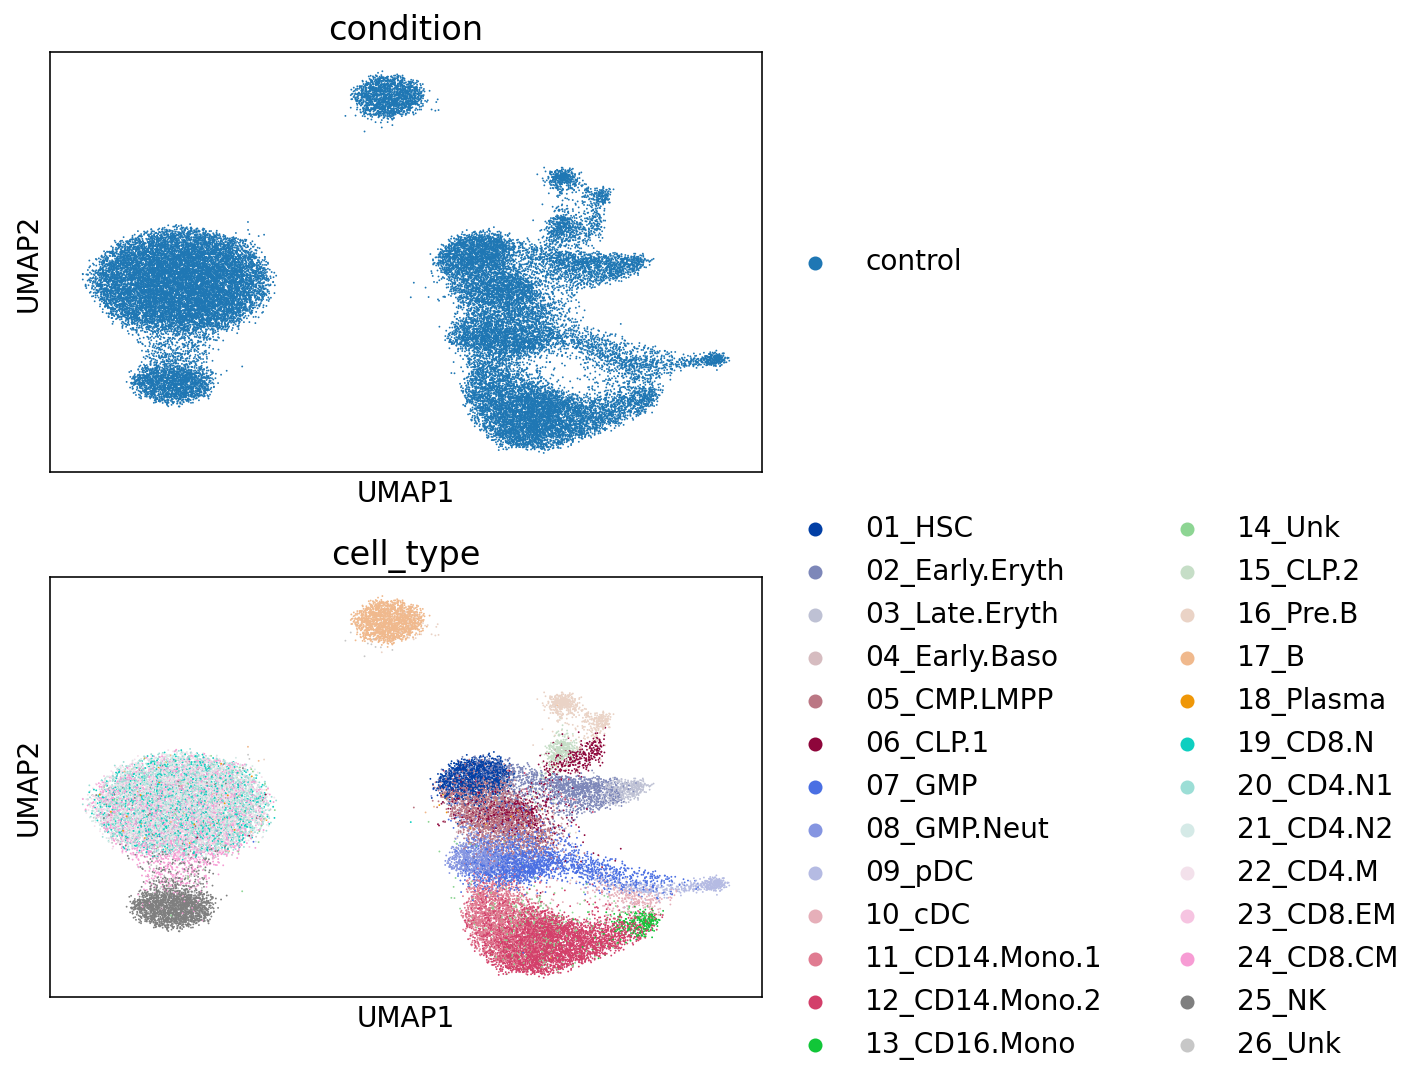

In [18]:
sc.pp.neighbors(scrna_latent, random_state=42)
sc.tl.umap(scrna_latent, random_state=42)
sc.pl.umap(scrna_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of scATAC-seq

In [19]:
scatac_encoder_labels, _ = multivae.utils.label_encoder(scatac, condition_key="condition")
scatac_latent = network.to_latent(scatac, scatac_encoder_labels, modal=1)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


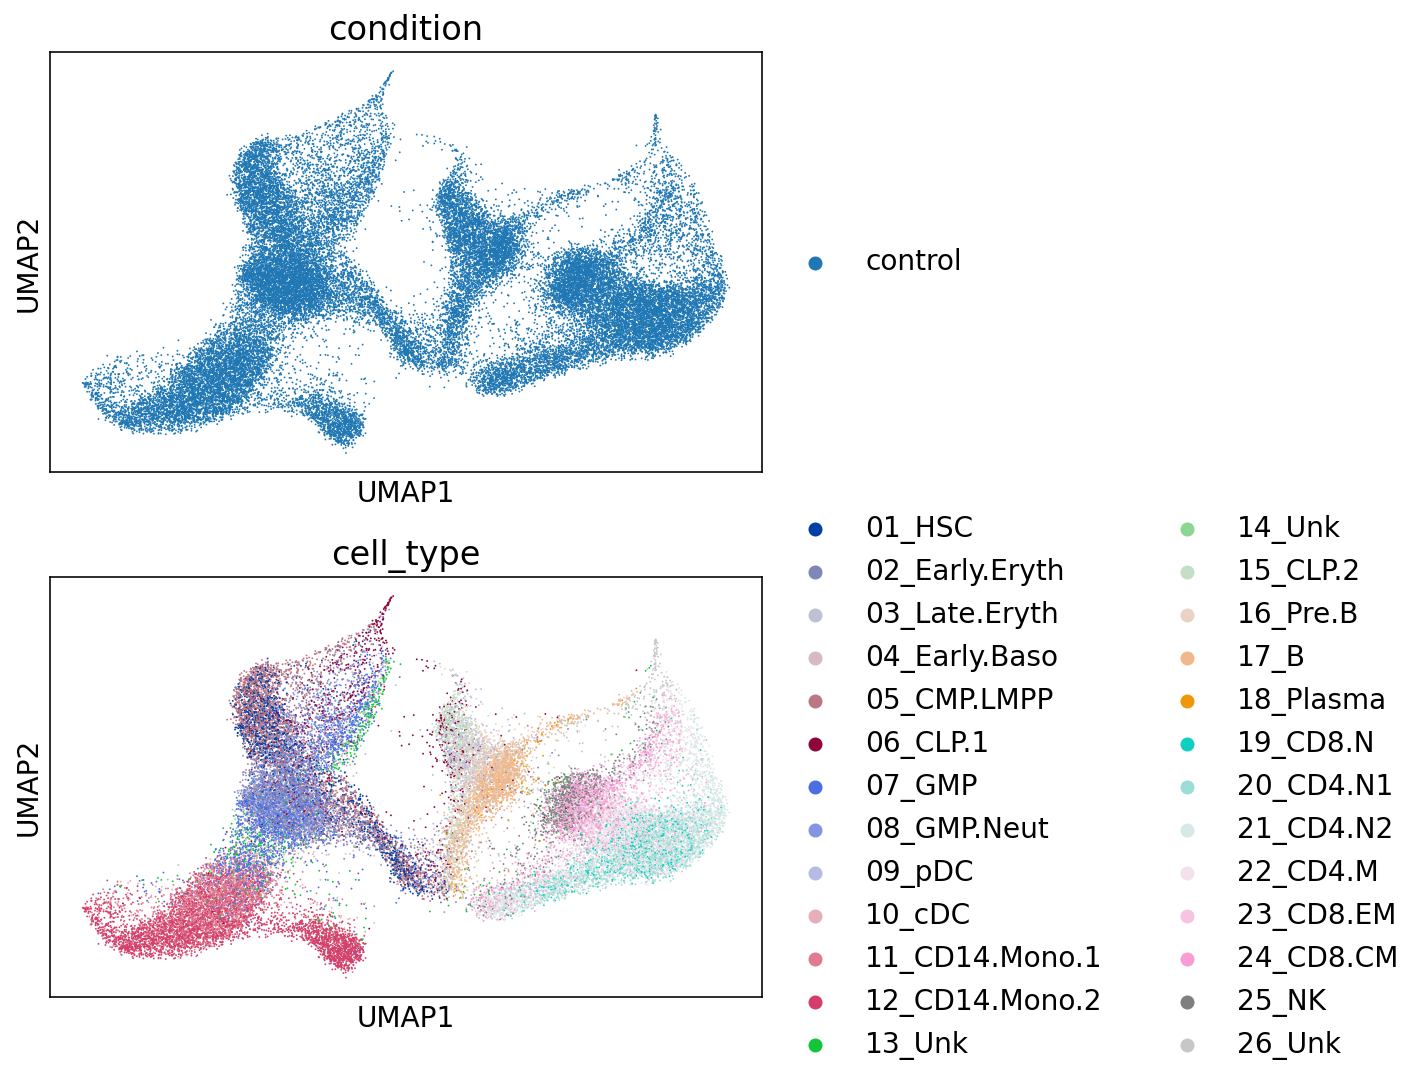

CPU times: user 1min 15s, sys: 1.22 s, total: 1min 17s
Wall time: 52.9 s


In [20]:
%%time
sc.pp.neighbors(scatac_latent, random_state=42)
sc.tl.umap(scatac_latent, random_state=42)
sc.pl.umap(scatac_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of both modalities

In [21]:
scall_latent = np.concatenate([scrna_latent.X, scatac_latent.X], axis=0)

scall_latent = sc.AnnData(scall_latent)
scrnaobs = scrna.obs.copy(deep=True)
scatacobs = scatac.obs.copy(deep=True)
scrnaobs['modality'] = 'scRNA-seq'
scatacobs['modality'] = 'scATAC-seq'

scall_latent.obs = pd.concat([scrnaobs, scatacobs])

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'modality' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical


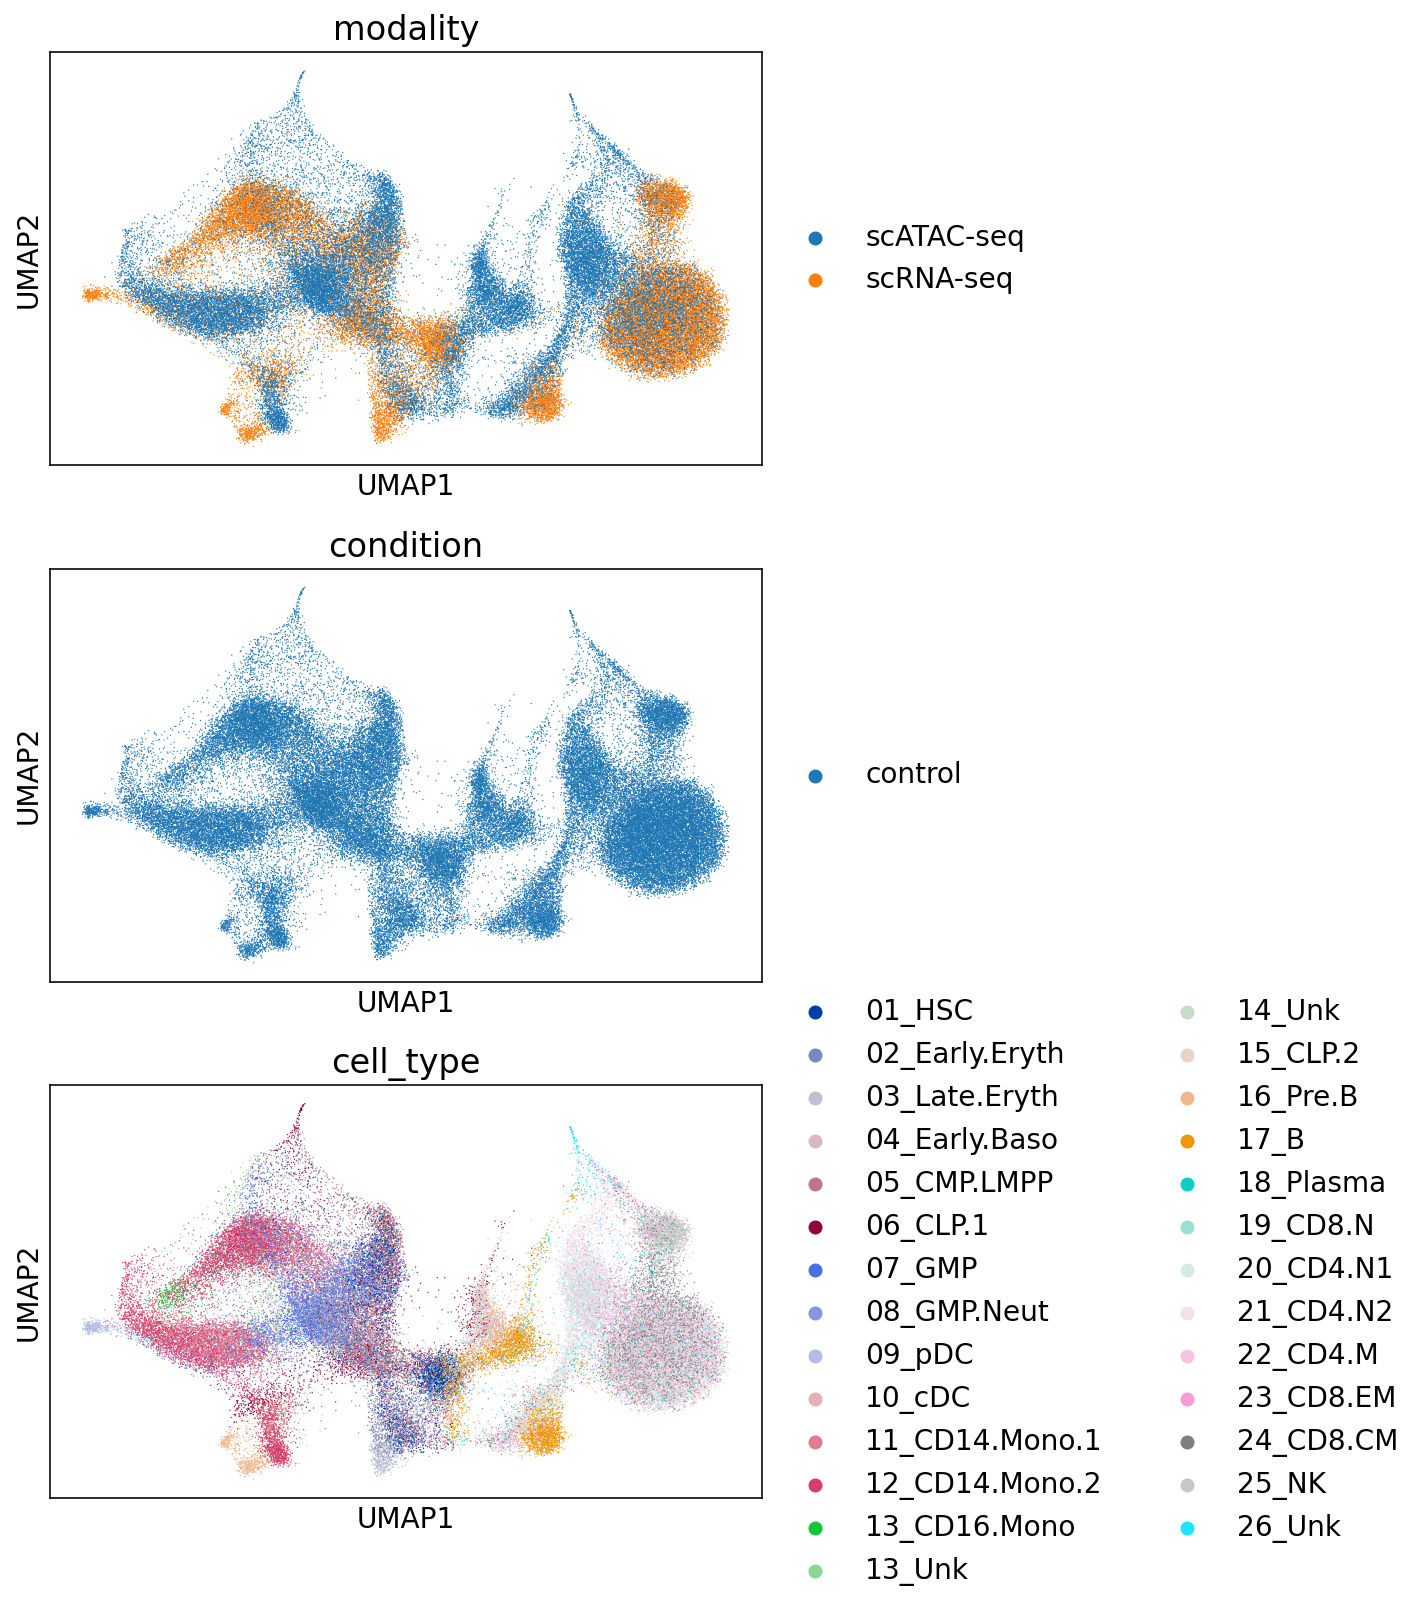

CPU times: user 4min 6s, sys: 4.47 s, total: 4min 10s
Wall time: 1min 58s


In [22]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modality', 'condition', 'cell_type'], ncols=1)

# Classify Cell-types

In [23]:
cell_type_x = scall_latent.X
cell_type_y = keras.utils.to_categorical(scall_latent.obs['cell_type'].cat.codes, 27)
rna_indices = scall_latent.obs['modality'] == 'scRNA-seq'
atac_indices = scall_latent.obs['modality'] == 'scATAC-seq'

In [24]:
clsfr_scrna = MLPClassifier(learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=80)
clsfr_scatac = MLPClassifier(learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=80)
clsfr_scall = MLPClassifier(learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=80)

In [25]:
clsfr_scrna.fit(cell_type_x[rna_indices], cell_type_y[rna_indices])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=80, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [26]:
clsfr_scatac.fit(cell_type_x[atac_indices], cell_type_y[atac_indices])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=80, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [27]:
clsfr_scall.fit(cell_type_x, cell_type_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=80, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

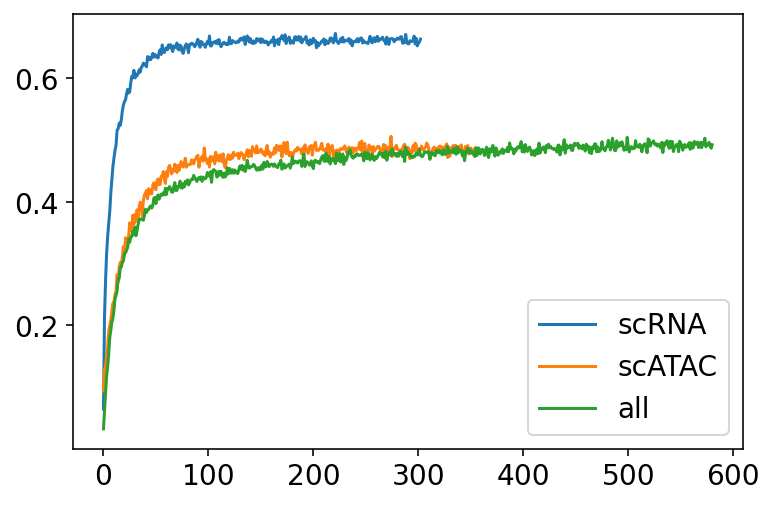

In [28]:
plt.plot(clsfr_scrna.validation_scores_, label='scRNA');
plt.plot(clsfr_scatac.validation_scores_, label='scATAC');
plt.plot(clsfr_scall.validation_scores_, label='all');
plt.legend();

In [29]:
clsfr_scrna.score(cell_type_x[atac_indices], cell_type_y[atac_indices])

0.05476910782578914

In [30]:
clsfr_scatac.score(cell_type_x[rna_indices], cell_type_y[rna_indices])

0.05003139448598664